# Annotation file lookup

**Importing necessary python packages**

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jams

**Importing annotation data**

In [49]:
# loading jams file for song
jams_file = '00_BN1-129-Eb_comp.jams'
j = jams.load('../data/raw/annotation/'+jams_file)

# accessing single pickups:
# j.annotations['pitch_contour'][0] # E string
# j.annotations['pitch_contour'][1] # A string
# j.annotations['pitch_contour'][2] # D string
# j.annotations['pitch_contour'][3] # G string
# j.annotations['pitch_contour'][4] # H string
# j.annotations['pitch_contour'][5] # e string

# storing data for high e string in 'data'
data = pd.DataFrame(j.annotations['pitch_contour'][5]) # E string
# extracting frequencies
freq = pd.json_normalize(data['value'])['frequency']
# merging frequencies with time data
df_time_freq = pd.concat([data['time'], freq], axis=1)

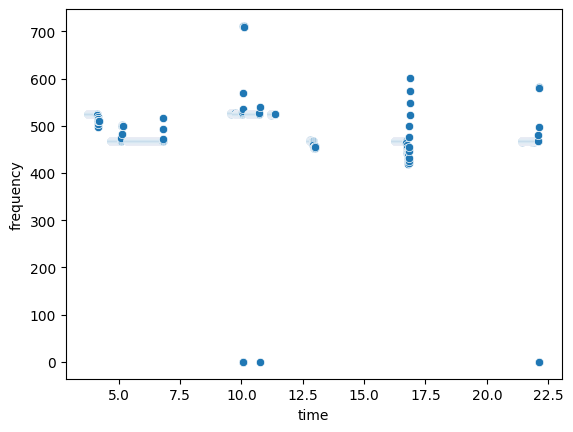

In [54]:
# displaying frequencies played on high e string over time
sns.scatterplot(data=df_time_freq, x='time', y='frequency');